<a href="https://colab.research.google.com/github/YinterestingProjects/human-wildlife-interactions/blob/main/notebooks/BERTopics_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install pandas==1.4.2 joblib==1.2.0 bertopic==0.14.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 3.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
import pickle
import pandas as pd
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer

RANDOM_SEED = 42

# directory setup
user = "sally"
#user = "jina"
#user = "josh"
     
try:
  if user == "sally":
    directory = '/content/drive/MyDrive/MADS/MADS_Capstone'
  elif user == "jina":
    directory = "JINA: INSERT YOUR PATH HERE"
  elif user == "josh":
    directory = "/content/drive/MyDrive/MADS_Capstone"
except:
  dprint("No user has been selected")

In [ ]:
fp = f'{directory}/data/processed/desc_title_translated.pkl'
corpus = pd.read_pickle(fp)

In [ ]:
def filter_null(df, verbose=True):
    '''filter null translations'''
    clean_corp = df[(df != ' ') & (df != '') & (df != 'source language unavailable for translation')]  
    if verbose:
        print(f'{len(df) - len(clean_corp)} null records dropped out of {len(df)}')  
    return clean_corp

In [ ]:
fp = f'{directory}/data/processed/desc_title_translated.pkl'
corpus = pd.read_pickle(fp)
  
order = corpus.index
new_doc = filter_null(corpus['title_en']).reset_index()
docs = new_doc['title_en']
docs
new_doc['index']

26 null records dropped out of 3895


0          0
1          1
2          2
3          3
4          4
        ... 
3864    3890
3865    3891
3866    3892
3867    3893
3868    3894
Name: index, Length: 3869, dtype: int64

In [ ]:
new_doc['index'][3868]

3894

In [ ]:
# ----------- topic modeling results --------------
# X [1]loop through search terms
# X [2]loop through similarity query threshold
# [3]loop through topics that are above threshold
# [4]find threshold cut offs of relevant videos from video-topics matix 
# [5]if video above threshold mark 1, else mark 0

# ----------- human annotation results --------------
# [1]loop through all available topics
# [2]find threshold cut offs of relevant videos from video-topics matix  (0.5) lower the better check n of video total to review
# [3][manual] loop through videos, show video, record human annonatation of hunting activity present (1) or not (0)


'''         Human Annot.
                0  1 
              -------
            0 |TN|FN|
 Topic        -------
 Modeling   1 |FP|TP|
              -------
'''

# threshold vs precision + recal curve
# precison = TP/(TP+FP)     
# recall = TP/(TP+FN)

'         Human Annot.\n                0  1 \n              -------\n            0 |TN|FN|\n Topic        -------\n Modeling   1 |FP|TP|\n              -------\n'

In [ ]:
# loop through all available topics
# find threshold cutoffs of relevant videos from video-topics matix  (0.5) lower the better check n of video total to review

# {
# topic1:[(video index, 0.3),(video index, 0.6), (video index, 0.9)],
# topic1:[(video index, 0.3),(video index, 0.6), (video index, 0.9)],
# topic1:[(video index, 0.3),(video index, 0.6), (video index, 0.9)],
# ...
#  }

# grab video per topic > 0.5 for human labeling




In [ ]:
BERTopic.load(f'{directory}/models/bertopic_bigram2')

In [ ]:
def get_topic_video_lookup(model_filepath, docs):
  ''' generate a topic to videos_id look up dictionary from saved model and training data corpus '''

  topic_model = BERTopic.load(model_filepath)
  topics, probs = topic_model.fit_transform(docs) # should this be fit_transform?? just transform ..?
  
  video_topic = list(zip(topics, probs))

  topic_video_lookup = {}
  for v_id, (topic, prob) in enumerate(video_topic):
    if topic not in topic_video_lookup:
      topic_video_lookup[topic] = [(v_id, prob)]
    else:
      topic_video_lookup[topic].append((v_id, prob))
  return topic_video_lookup


In [ ]:
trigram_tp_lookup = get_topic_video_lookup(f'{directory}/models/bertopic_trigram', docs)
bigram_tp_lookup = get_topic_video_lookup(f'{directory}/models/bertopic_bigram', docs)
guided_tp_lookup = get_topic_video_lookup(f'{directory}/models/bertopic_guided', docs)

In [ ]:
# model_fp = f'{directory}/models/bertopic_trigram'
# topic_model = BERTopic.load(model_fp)
# topics, probs = topic_model.fit_transform(docs)

# trigram_tp_lookup = get_topic_video_lookup(topics, probs)


# model_fp = f'{directory}/models/bertopic_bigram'
# topic_model = BERTopic.load(model_fp)
# topics, probs = topic_model.fit_transform(docs)

# bigram_tp_lookup = get_topic_video_lookup(topics, probs)


# model_fp = f'{directory}/models/bertopic_guided'
# topic_model = BERTopic.load(model_fp)
# topics, probs = topic_model.fit_transform(docs)

# guided_tp_lookup = get_topic_video_lookup(topics, probs)

In [ ]:
print(f'outlier videos count guided {len(guided_tp_lookup[-1])}')
print(f'outlier videos count bigram {len(bigram_tp_lookup[-1])}')
print(f'outlier videos count trigram {len(trigram_tp_lookup[-1])}')

outlier videos count guided 1126
outlier videos count bigram 1281
outlier videos count trigram 1281


In [ ]:
# filter list by threshold 0.5, find total

def count_videos(lookup):
  count = 0
  for topic in lookup:
    count += len(lookup[topic]) 
  return count

def count_empty_topics(lookup):
  count = 0
  for topic in lookup:
    if len(lookup[topic]) == 0:
      count += 1
      #print(topic)
    return count

def get_videos_by_topic_threshold(lookup, threshold=0.5):
  '''filter a video topic lookup based on threshold of topic video '''
  
  filtered_videos = {}
  for topic in lookup:
    filtered_videos[topic] = [(v_id, prob) for v_id, prob in lookup[topic] if prob > threshold]
    
  print(f'videos remaining: {count_videos(filtered_videos)}/{count_videos(lookup)}, empty topic count {count_empty_topics(filtered_videos)}/{count_empty_topics(lookup)}')
  return filtered_videos

In [ ]:
filtered = get_videos_by_topic_threshold(trigram_tp_lookup, threshold=0.5)
filtered = get_videos_by_topic_threshold(trigram_tp_lookup, threshold=0.6)
filtered = get_videos_by_topic_threshold(trigram_tp_lookup, threshold=0.7)
filtered = get_videos_by_topic_threshold(trigram_tp_lookup, threshold=0.9)
filtered = get_videos_by_topic_threshold(trigram_tp_lookup, threshold=0.95)
filtered = get_videos_by_topic_threshold(trigram_tp_lookup, threshold=0.999999)

videos remaining: 2330/3869, empty topic count 1/0
videos remaining: 2178/3869, empty topic count 1/0
videos remaining: 1995/3869, empty topic count 1/0
videos remaining: 1510/3869, empty topic count 1/0
videos remaining: 1339/3869, empty topic count 1/0
videos remaining: 1187/3869, empty topic count 1/0


In [ ]:
filtered = get_videos_by_topic_threshold(bigram_tp_lookup, threshold=0.5)
filtered = get_videos_by_topic_threshold(bigram_tp_lookup, threshold=0.6)
filtered = get_videos_by_topic_threshold(bigram_tp_lookup, threshold=0.7)
filtered = get_videos_by_topic_threshold(bigram_tp_lookup, threshold=0.9)
filtered = get_videos_by_topic_threshold(bigram_tp_lookup, threshold=0.95)
filtered = get_videos_by_topic_threshold(bigram_tp_lookup, threshold=0.999999)

videos remaining: 2330/3869, empty topic count 1/0
videos remaining: 2178/3869, empty topic count 1/0
videos remaining: 1995/3869, empty topic count 1/0
videos remaining: 1510/3869, empty topic count 1/0
videos remaining: 1339/3869, empty topic count 1/0
videos remaining: 1187/3869, empty topic count 1/0


In [ ]:
filtered = get_videos_by_topic_threshold(guided_tp_lookup, threshold=0.5)
filtered = get_videos_by_topic_threshold(guided_tp_lookup, threshold=0.6)
filtered = get_videos_by_topic_threshold(guided_tp_lookup, threshold=0.7)
filtered = get_videos_by_topic_threshold(guided_tp_lookup, threshold=0.9)
filtered = get_videos_by_topic_threshold(guided_tp_lookup, threshold=0.95)
filtered = get_videos_by_topic_threshold(guided_tp_lookup, threshold=0.999999)

videos remaining: 2316/3869, empty topic count 1/0
videos remaining: 2074/3869, empty topic count 1/0
videos remaining: 1850/3869, empty topic count 1/0
videos remaining: 1227/3869, empty topic count 1/0
videos remaining: 1052/3869, empty topic count 1/0
videos remaining: 858/3869, empty topic count 1/0


In [ ]:
# randomly sample 300? 

In [ ]:
def update_video_index(filtered_lookup, index_key):
  '''updating video indexes of the filtered topic video look to original video dataframe index'''

  updated_lookup = {}
  for topic in filtered_lookup:
    video_list = []
    for v_id, prob in filtered_lookup[topic]:
      video_list.append((index_key[v_id],prob))
    updated_lookup[topic] = video_list
  
  return updated_lookup 

In [ ]:
filtered[1][:10]

[(4, 1.0),
 (5, 1.0),
 (195, 1.0),
 (451, 1.0),
 (566, 1.0),
 (619, 1.0),
 (629, 1.0),
 (707, 1.0),
 (780, 1.0),
 (790, 1.0)]

In [ ]:
updated_filtered = update_video_index(filtered, new_doc['index'])
updated_filtered[1][:10]

[(4, 1.0),
 (5, 1.0),
 (200, 1.0),
 (456, 1.0),
 (571, 1.0),
 (624, 1.0),
 (634, 1.0),
 (714, 1.0),
 (787, 1.0),
 (797, 1.0)]

In [ ]:
corpus

,yt8M_id,id,snippet.title,snippet.description,snippet.tags,title_clean,title_src_lang,title_src_conf,title_en,desc_clean,desc_src_lang,desc_src_conf,desc_en
0,HTft,130S1TN3P0M,Obserwator 22: Jesień na tamie / Autumn on a ...,To już pożegnanie z tamą bobrową. Jesień zawit...,"[Łoś, Alces alces, Elk (Animal), wiewiórka, Sq...",Obserwator 22: Jesień na tamie / Autumn on a ...,pl,0.3335,Observer 22: Autumn on a Beaver's Dam,To już pożegnanie z tamą bobrową. Jesień zawit...,pl,0.9448,This is already a goodbye to that bobrow. Autu...
1,VX3C,iHpgw8WN6Bg,bébés ocelots et otocyons au Domaine des Fauves,"les bébés ocelots âgés de 7 semaines, arrivée ...","[zoo, isère, le, domaine, des, fauves, ocelots...",bébés ocelots et otocyons au Domaine des Fauves,fr,0.9698,Babies and Otocyons in the Domaine des Fauves,"les bébés ocelots âgés de 7 semaines, arrivée ...",fr,0.8944,"Babies aged 7 weeks, arrived from a couple of ..."
2,j2Er,XrX9NBMUOzw,Two Giraffe Calves born at the San Francisco Zoo,Follow the zoo: \r\nhttp://twitter.com/sfzoo\r...,"[wildlife, giraffe, sfzoobehindthescenes, birt...",Two Giraffe Calves born at the San Francisco Zoo,en,0.9882,Two Giraffe Calves born at the San Francisco Zoo,Follow the zoo: Reticulated Giraffe Calves we...,en,0.9758,Follow the zoo: Reticulated Giraffe Calves we...
3,3HOO,qwL5HKti-dw,Fauna salbatica bucovineana in fotografi - Buk...,#WildBucovina Natura si fauna sălbatică din Bu...,"[Cerbi carpatini, Capriori, Deer, Landscapes.,...",Fauna salbatica bucovineana in fotografi - Buk...,en,0.2253,Fauna salbatica bucovineana in fotografi - Buk...,#WildBucovina Natura si fauna sălbatică din Bu...,ro,0.7316,Nature and fauna is the gift God gave people t...
4,6nfW,wPJy9D_kzVU,Wyoming Archery Mule Deer Hunt With Joe Thomas...,,"[New, Project]",Wyoming Archery Mule Deer Hunt With Joe Thomas...,en,0.6670,Wyoming Archery Mule Deer Hunt With Joe Thomas...,,en,0.1245,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,eG3r,TbptwoQYcgA,Outside with the Animals Vol. 2 (October),October's edition of Outside with the Animals....,"[camels, dromedary camel, sheep, mouflon, shet...",Outside with the Animals Vol. 2 (October),en,0.7690,Outside with the Animals Vol. 2 (October),October's edition of Outside with the Animals....,en,0.9261,October's edition of Outside with the Animals....
3891,x3kS,jGKxLy1fjRI,Roaring Lion at the Brookfield Zoo,"Zenda, the male Lion at Brookfield Zoo (Just o...","[Lion, Roar, Brookfield Zoo, Zoo, male lion]",Roaring Lion at the Brookfield Zoo,en,0.7827,Roaring Lion at the Brookfield Zoo,"Zenda, the male Lion at Brookfield Zoo (Just o...",en,0.7978,"Zenda, the male Lion at Brookfield Zoo (Just o..."
3892,RD6R,lpcca8eyw98,EL PARQUE KRUGER - AVENTURA SUDAFRICA CANAL OF...,No existe un santuario para la vida salvaje co...,"[KrugerMpeg, Tourism]",EL PARQUE KRUGER - AVENTURA SUDAFRICA CANAL OF...,de,0.4327,El Parque Cruz - Aventura Sudáfrica Canal Offi...,No existe un santuario para la vida salvaje co...,es,0.9785,There is no sanctuary for wildlife like the Kr...
3893,xvSB,_u-CJqtesgc,Lion Safari Tour @ Gir Forest Gujarat,Lion Safari Tour @ Gir Forest Gujarat,"[India, wildlife safari, jungle ride, lions & ...",Lion Safari Tour @ Gir Forest Gujarat,en,0.2784,Lion Safari Tour @ Gir Forest Gujarat,Lion Safari Tour @ Gir Forest Gujarat,en,0.2784,Lion Safari Tour @ Gir Forest Gujarat


In [ ]:
# random (fixed) sampling
{topic: len(updated_filtered[topic]) for topic in updated_filtered}

{-1: 0,
 39: 10,
 9: 10,
 1: 74,
 53: 10,
 0: 11,
 31: 10,
 4: 10,
 11: 10,
 13: 10,
 3: 133,
 25: 10,
 40: 10,
 33: 10,
 7: 44,
 44: 10,
 27: 10,
 5: 10,
 15: 10,
 19: 10,
 23: 11,
 42: 10,
 28: 10,
 55: 10,
 34: 10,
 8: 10,
 50: 10,
 6: 10,
 48: 10,
 16: 11,
 24: 10,
 18: 10,
 43: 10,
 32: 10,
 14: 10,
 21: 10,
 10: 10,
 2: 41,
 17: 10,
 54: 10,
 57: 10,
 35: 11,
 12: 10,
 30: 10,
 26: 10,
 20: 10,
 37: 10,
 38: 10,
 49: 10,
 36: 10,
 59: 10,
 58: 10,
 22: 10,
 51: 10,
 46: 10,
 47: 10,
 41: 10,
 45: 10,
 29: 12,
 56: 10,
 52: 10}

In [ ]:
from IPython.display import YouTubeVideo

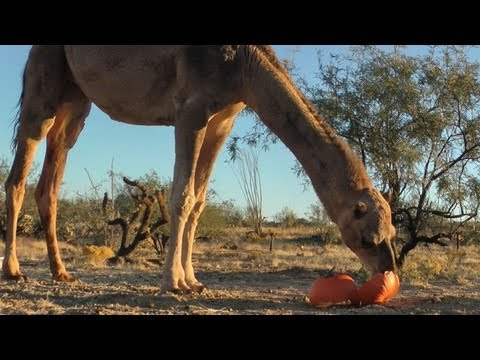

In [ ]:
YouTubeVideo('TbptwoQYcgA')

- init video buffer
- loop through {topic: video list}
- find 5 videos, fixed random 
- show youtube video 
- record human annotation into buffer {key(real_yt_id): annotation}



In [41]:
import random

def sample_videos(topic_video_dictionary):
  '''sample 5 randam videos for each topic to label'''
  sampled_dict = {}
  for topic in topic_video_dictionary:
    if topic != -1:
      random.seed(RANDOM_SEED)
      videos = random.choices(topic_video_dictionary[topic], k=5)
      sampled_dict[topic] = videos
  return sampled_dict


def get_labels(sampled_dictionary):
  



get_labels(sample_videos(updated_filtered))

{39: [(2605, 1.0), (98, 1.0), (463, 1.0), (463, 1.0), (3399, 1.0)],
 9: [(2963, 1.0), (955, 1.0), (1564, 1.0), (1564, 1.0), (3272, 1.0)],
 1: [(2523, 1.0), (5, 1.0), (1080, 1.0), (1032, 1.0), (2909, 1.0)],
 53: [(3410, 1.0), (7, 1.0), (388, 1.0), (388, 1.0), (3598, 1.0)],
 0: [(3283, 1.0), (105, 1.0), (1873, 1.0), (1867, 1.0), (3371, 1.0)],
 31: [(3264, 1.0), (176, 1.0), (1690, 1.0), (1690, 1.0), (3554, 1.0)],
 4: [(2923, 1.0), (519, 1.0), (672, 1.0), (672, 1.0), (3097, 1.0)],
 11: [(2415, 1.0), (35, 1.0), (991, 1.0), (991, 1.0), (2852, 1.0)],
 13: [(1993, 1.0), (14, 1.0), (246, 1.0), (246, 1.0), (2018, 1.0)],
 3: [(2373, 1.0), (76, 1.0), (1027, 1.0), (831, 1.0), (2836, 1.0)],
 25: [(2068, 1.0), (17, 1.0), (494, 1.0), (494, 1.0), (2194, 1.0)],
 40: [(2078, 1.0), (80, 1.0), (1091, 1.0), (1091, 1.0), (2196, 1.0)],
 33: [(3289, 1.0), (273, 1.0), (1399, 1.0), (1399, 1.0), (3308, 1.0)],
 7: [(2694, 1.0), (88, 1.0), (1625, 1.0), (1279, 1.0), (3060, 1.0)],
 44: [(3148, 1.0), (379, 1.0), (1559

In [33]:
random.seed(RANDOM_SEED)
random.choices(updated_filtered[1], k=5)

[(2523, 1.0), (5, 1.0), (1080, 1.0), (1032, 1.0), (2909, 1.0)]

In [29]:

random.seed(RANDOM_SEED)
country, capital = random.choice(list(d.items()), size=5)

x = input('Enter 1 if video involves hunting, 0 elsewise :')

updated_filtered

{-1: [],
 39: [(98, 1.0),
  (197, 1.0),
  (463, 1.0),
  (816, 1.0),
  (1275, 1.0),
  (2568, 1.0),
  (2605, 1.0),
  (3399, 1.0),
  (3699, 1.0),
  (3861, 1.0)],
 9: [(955, 1.0),
  (1512, 1.0),
  (1564, 1.0),
  (1599, 1.0),
  (2167, 1.0),
  (2541, 1.0),
  (2963, 1.0),
  (3272, 1.0),
  (3330, 1.0),
  (3770, 1.0)],
 1: [(4, 1.0),
  (5, 1.0),
  (200, 1.0),
  (456, 1.0),
  (571, 1.0),
  (624, 1.0),
  (634, 1.0),
  (714, 1.0),
  (787, 1.0),
  (797, 1.0),
  (854, 1.0),
  (877, 1.0),
  (900, 1.0),
  (946, 1.0),
  (952, 1.0),
  (1025, 1.0),
  (1032, 1.0),
  (1046, 1.0),
  (1047, 1.0),
  (1070, 1.0),
  (1080, 1.0),
  (1117, 1.0),
  (1181, 1.0),
  (1203, 1.0),
  (1229, 1.0),
  (1387, 1.0),
  (1400, 1.0),
  (1403, 1.0),
  (1408, 1.0),
  (1441, 1.0),
  (1517, 1.0),
  (1670, 1.0),
  (1700, 1.0),
  (1729, 1.0),
  (1776, 1.0),
  (1791, 1.0),
  (1797, 1.0),
  (1804, 1.0),
  (1934, 1.0),
  (2060, 1.0),
  (2071, 1.0),
  (2100, 1.0),
  (2127, 1.0),
  (2309, 1.0),
  (2324, 1.0),
  (2351, 1.0),
  (2507, 1.0),